# Import libraries

In [91]:
import os
from re import search
from dfply import *
import igraph
import fa2

# Load settings

In [92]:
if search("ricard", os.uname()[1]):
    exec(open('/Users/argelagr/gastrulation10x/settings.py').read())
    exec(open('/Users/ricard/gastrulation10x/utils.py').read())
elif search("BI2404M", os.uname()[1]):
    exec(open('/Users/argelagr/gastrulation10x/settings.py').read())
    exec(open('/Users/argelagr/gastrulation10x/utils.py').read())
else:
    exit("Computer not recognised")

## Define I/O

In [93]:
io["outdir"] = io["basedir"] + "/results/trajectories/test"

## Define options 

scanpy options

In [94]:
# %%capture
# sc.settings.verbosity = 3
# sc.logging.print_versions()
sc.settings.figdir = io["outdir"]
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(8, 7), facecolor='white')

In [95]:
opts["stages"] = [
#	"E6.5",
#	"E6.75",
#	"E7.0",
#	"E7.25",
	"E7.5",
	"E7.75",
	"E8.0",
	"E8.25",
	"E8.5",
	"mixed_gastrulation"
]

opts["celltypes"] = [
#   "Epiblast",
#   "Primitive_Streak",
#   "Caudal_epiblast",
   "Caudal_Mesoderm",
   "Somitic_mesoderm",
   "NMP",
   "Spinal_cord"
]

## Load cell metadata

In [96]:
metadata = (pd.read_table(io["metadata"]) >>
    mask(X["stripped"]==False, X["doublet"]==False) >>
    mask(X["stage"].isin(opts["stages"]), X["celltype"].isin(opts["celltypes"]))
)
metadata.shape

(6990, 12)

In [97]:
metadata.head()

,cell,barcode,sample,stage,sequencing.batch,doublet,stripped,celltype,umapX,umapY,nFeature_RNA,nCount_RNA
7,cell_100002,GACTGATGTCCCAC,29,E8.5,3,False,False,Spinal_cord,1.995580,-4.249367,3477,17315
8,cell_100003,GACTGTGACACTCC,29,E8.5,3,False,False,Spinal_cord,1.339748,-5.684256,2998,12035
13,cell_100008,GACTGTGAGTTCGA,29,E8.5,3,False,False,Spinal_cord,1.205669,-3.958545,2386,6960
18,cell_100013,GACTTTACGTCCTC,29,E8.5,3,False,False,NMP,2.894028,-0.207476,3989,22005
19,cell_100014,GACTTTACTAGCGT,29,E8.5,3,False,False,NMP,2.769748,0.486420,3233,13290


# Load anndata object

In [98]:
adata = load_adata(
    adata_file = io["anndata"], 
    metadata_file = io["metadata"],
    cells = metadata.cell.values, 
    normalise = True, 
    filter_lowly_expressed_genes = True
)
adata

/Users/argelagr/opt/anaconda3/envs/main/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/argelagr/opt/anaconda3/envs/main/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 6990 × 15121
    obs: 'cell', 'barcode', 'sample', 'stage', 'sequencing.batch', 'doublet', 'stripped', 'celltype', 'umapX', 'umapY', 'nFeature_RNA', 'nCount_RNA'
    var: 'n_counts'
    uns: 'celltype_colors', 'clusterMergedHierarchy_colors', 'clusterMergedHierarchy_sizes', 'clusterSubUnique_colors', 'clusterSubUnique_sizes', 'diffmap_evals', 'neighbors', 'paga', 'stage_colors', 'log1p'
    obsm: 'X_pca', 'X_umap', 'X_tsne', 'X_diffmap'
    obsp: 'distances', 'connectivities'

In [99]:
adata.obs["celltype"].value_counts()

Somitic_mesoderm    2079
NMP                 2041
Spinal_cord         1796
Caudal_Mesoderm     1074
Name: celltype, dtype: int64

/Users/argelagr/opt/anaconda3/envs/main/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'barcode' as categorical
/Users/argelagr/opt/anaconda3/envs/main/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'stage' as categorical
/Users/argelagr/opt/anaconda3/envs/main/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated

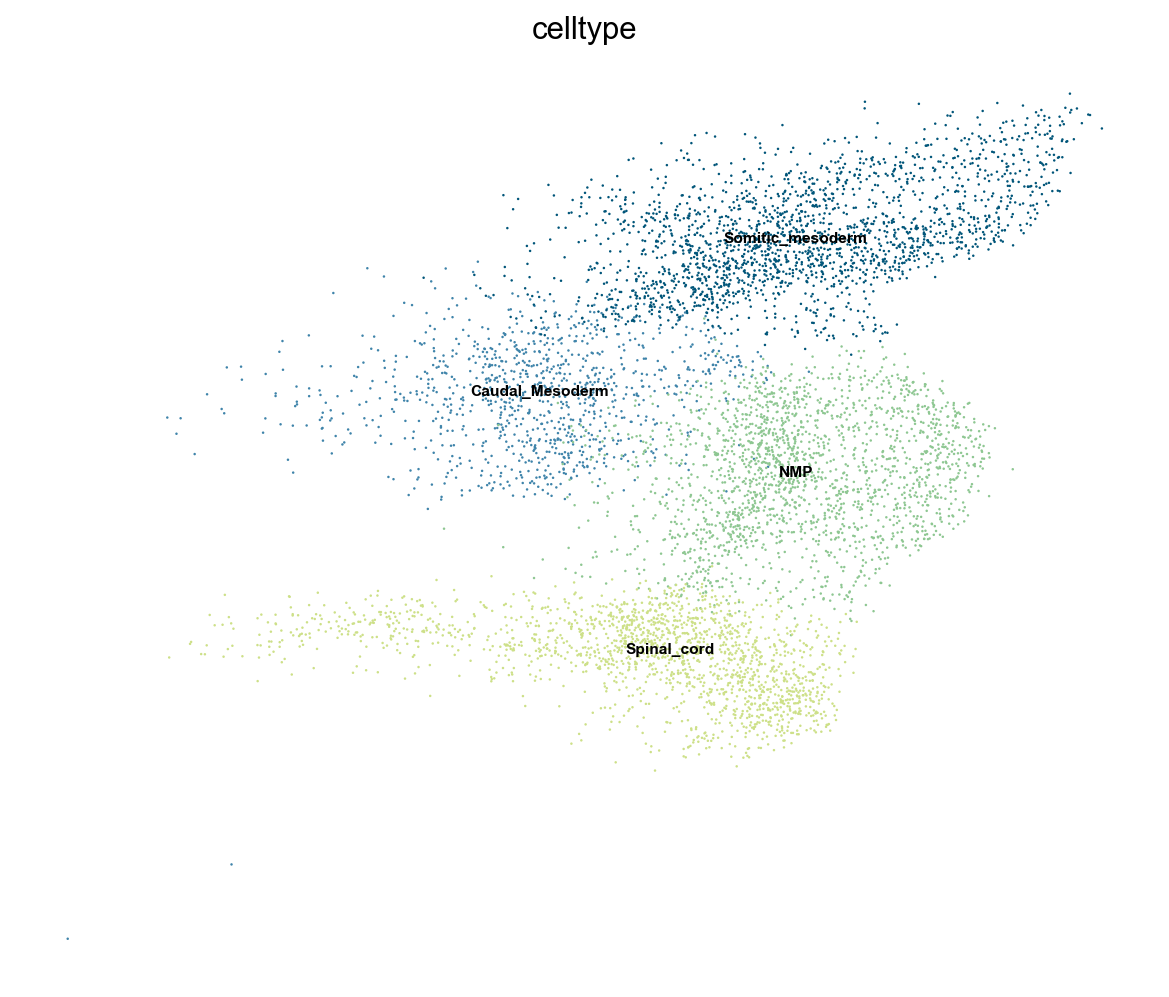

In [100]:
sc.pl.scatter(adata, color='celltype', basis="umap", size=5, legend_loc='on data', legend_fontsize=7)

## Feature selection

In [101]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)

In [102]:
adata.var["highly_variable"].sum()

1000

## Dimensionality reduction

### PCA

In [103]:
sc.tl.pca(adata, n_comps=15)

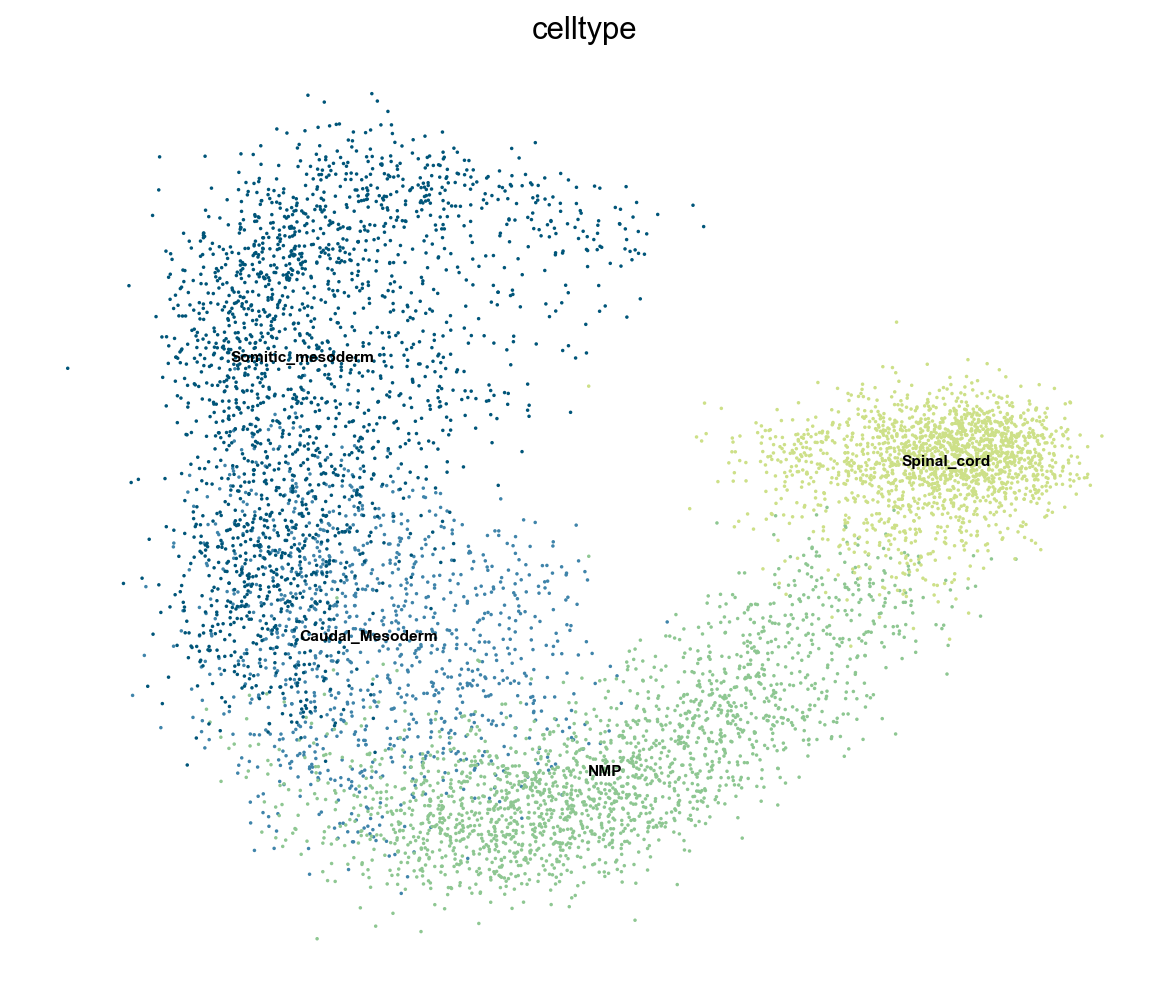

In [104]:
sc.pl.scatter(adata, color='celltype', basis="pca", size=10, legend_loc='on data', legend_fontsize=7, 
              save="nmp_pca_celltype.pdf")

## Batch effect correction

In [105]:
sc.external.pp.harmony_integrate(adata, "stage", basis='X_pca', adjusted_basis='X_pca_harmony')

2022-02-19 15:20:14,137 - harmonypy - INFO - Iteration 1 of 10
2022-02-19 15:20:15,466 - harmonypy - INFO - Iteration 2 of 10
2022-02-19 15:20:16,713 - harmonypy - INFO - Iteration 3 of 10
2022-02-19 15:20:17,961 - harmonypy - INFO - Iteration 4 of 10
2022-02-19 15:20:19,305 - harmonypy - INFO - Iteration 5 of 10
2022-02-19 15:20:20,608 - harmonypy - INFO - Iteration 6 of 10
2022-02-19 15:20:21,867 - harmonypy - INFO - Iteration 7 of 10
2022-02-19 15:20:23,185 - harmonypy - INFO - Iteration 8 of 10
2022-02-19 15:20:24,490 - harmonypy - INFO - Iteration 9 of 10
2022-02-19 15:20:25,780 - harmonypy - INFO - Iteration 10 of 10
2022-02-19 15:20:26,674 - harmonypy - INFO - Converged after 10 iterations


## Compute neighbors

In [106]:
#sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca')
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca_harmony')

### UMAP

In [107]:
sc.tl.umap(adata, min_dist=0.3, spread=1.0)

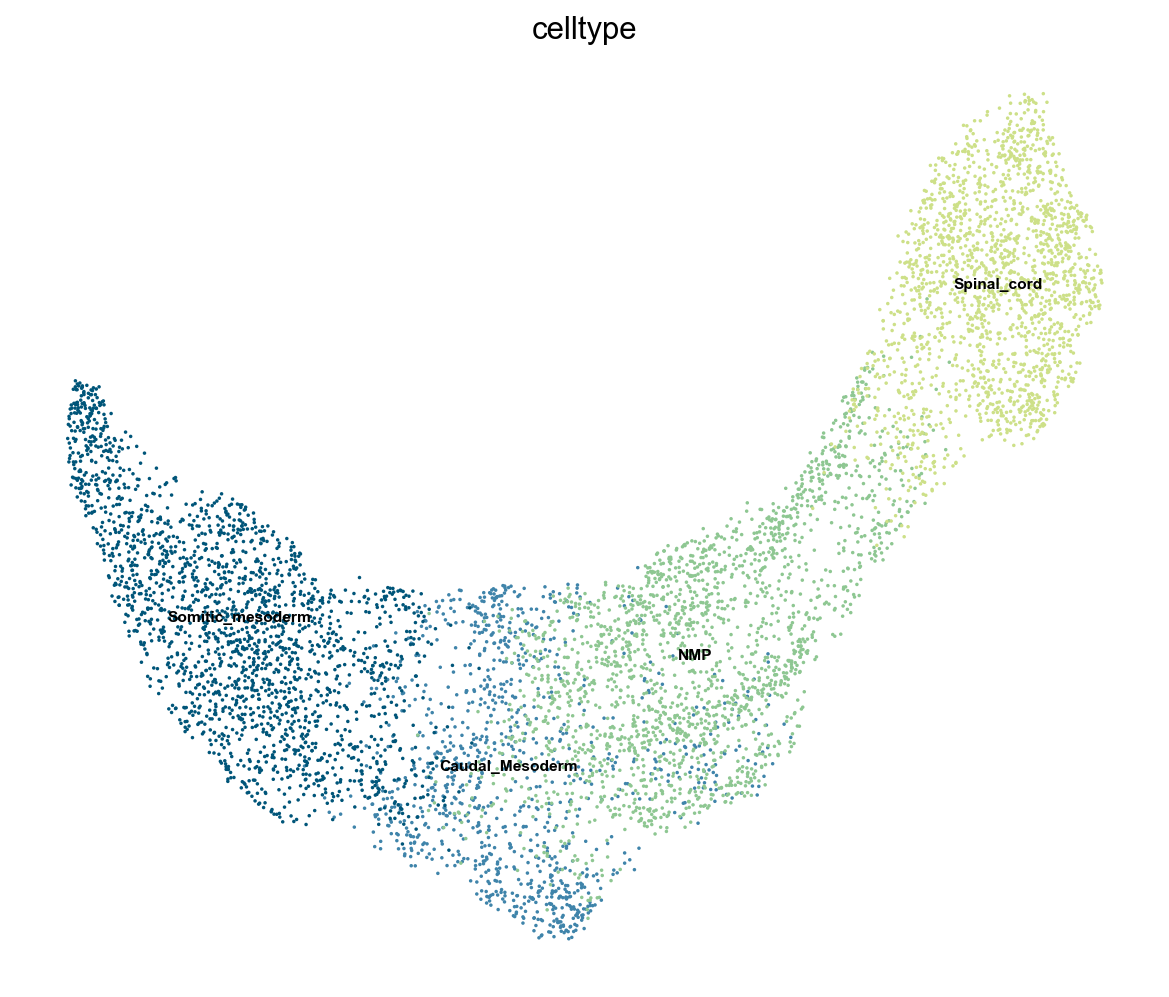

In [108]:
sc.pl.scatter(adata, color='celltype', basis="umap", size=10, legend_loc='on data', legend_fontsize=7,
              save = "blood_umap_celltype.pdf")

In [109]:
adata.obsm.keys()

KeysView(AxisArrays with keys: X_pca, X_umap, X_tsne, X_diffmap, X_pca_harmony)

### Force-directed layout

In [110]:
sc.tl.draw_graph(adata, layout='fa', init_pos=None)

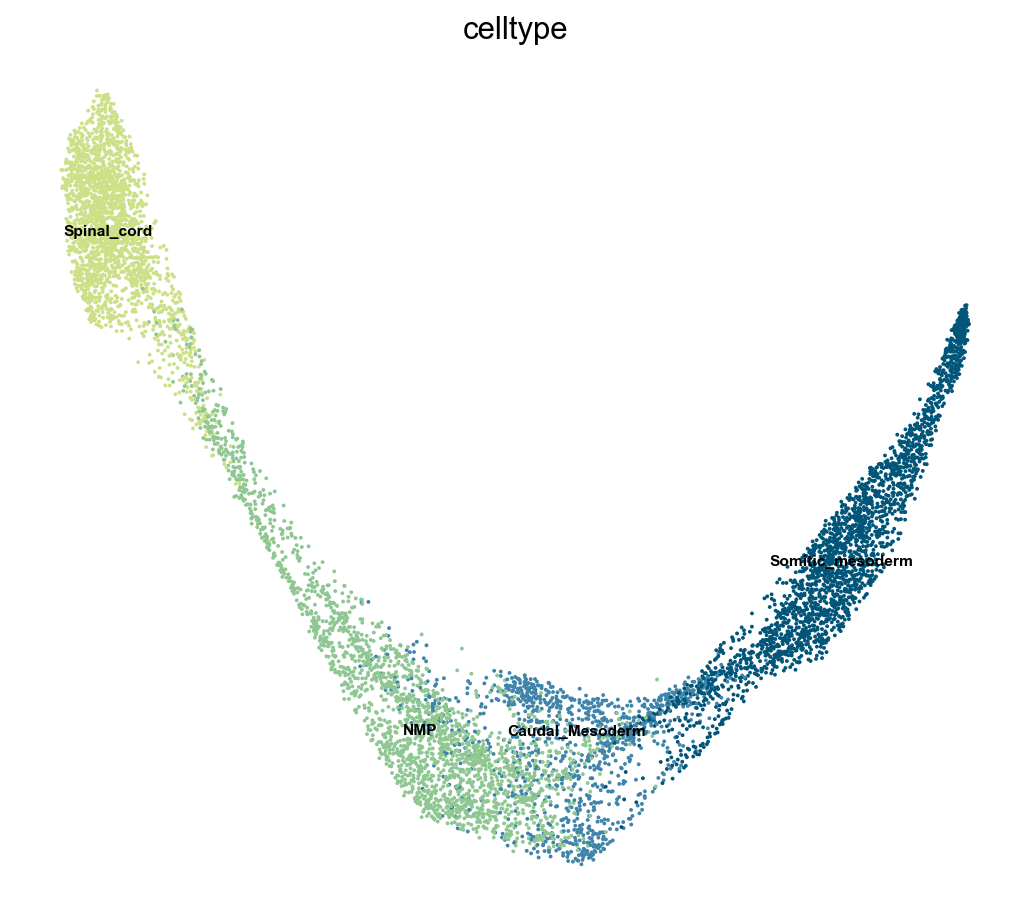

In [111]:
# sc.pl.draw_graph(adata, color='celltype', legend_loc='on data')
sc.pl.draw_graph(adata, color='celltype', size=12, legend_loc='on data', legend_fontsize=7,
              save = "nmp_fa2_celltype.pdf")

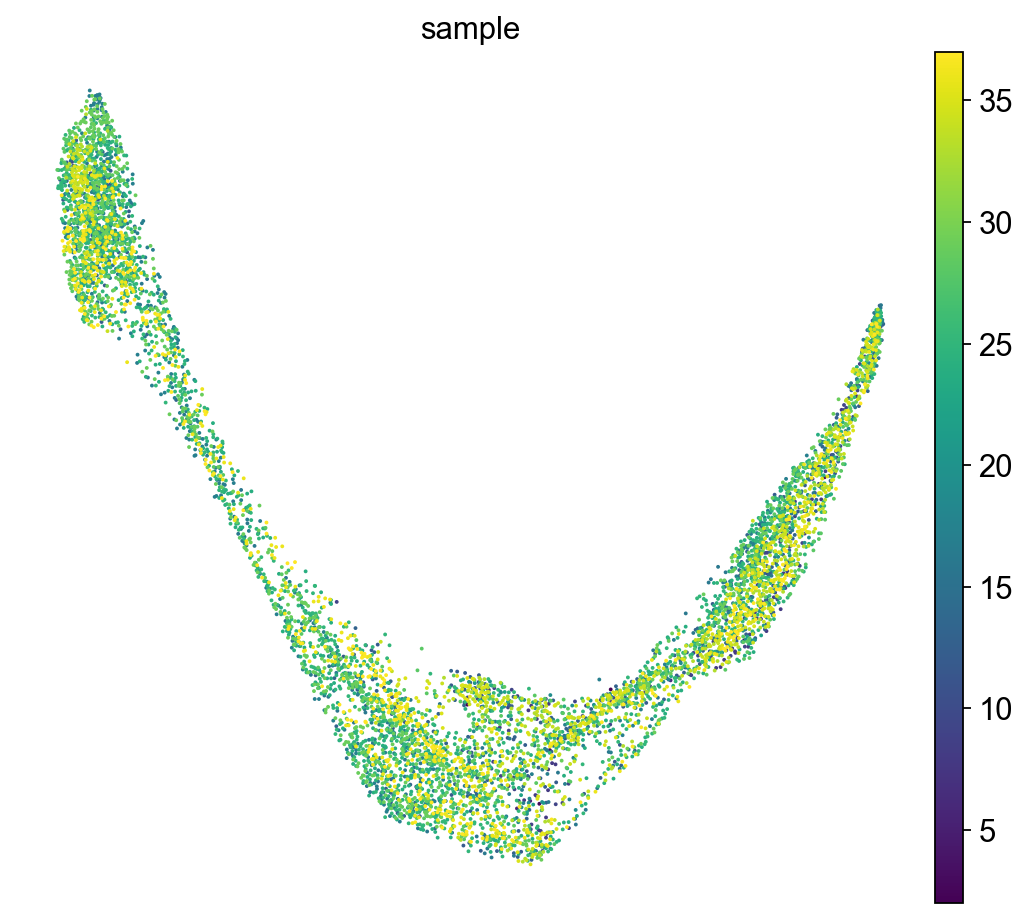

In [112]:
sc.pl.draw_graph(adata, color='sample', size=12, legend_loc='on data', legend_fontsize=7, save = "nmp_fa2_sample.pdf")

## Save

In [115]:
trajectory = pd.DataFrame(adata.obsm["X_draw_graph_fa"], index=adata.obs_names, columns=["FA1","FA2"])
trajectory.to_csv(io["outdir"] + "/nmp_trajectory.txt.gz", sep='\t')

In [118]:
adata.write(io["outdir"] + "/nmp_anndata.h5ad")
metadata.to_csv(io["outdir"] + "/nmp_sample_metadata.txt.gz", sep='\t')